In [1]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from mymetrics import *
import time
# import plotly.express as px
# import plotly.offline as pyo
# pyo.init_notebook_mode()

df = pd.read_csv('./data/user_taggedmovies.dat',sep="\s+", )
# df.iloc[:,1] = 'I-'+df.iloc[:,1].astype('str')
# Generate temporal features
df.loc[:,'timestamps'] = df.date_year.astype('str')+'_'+ df.date_month.astype('str')+'_'+ df.date_day.astype('str')+'_'+ \
df.date_hour.astype('str')+'_'+df.date_minute.astype('str')+'_'+df.date_second.astype('str')
df.loc[:,'timestamps'] = df.loc[:,'timestamps'].apply(pd.to_datetime,format='%Y_%m_%d_%H_%M_%S')
df['dayofweek_num']=df['timestamps'].dt.dayofweek  
df['weekofyear']=df['timestamps'].dt.weekofyear
df['quarter']=df['timestamps'].dt.quarter
df['days_in_month']=df['timestamps'].dt.days_in_month
df['is_month_start']=df['timestamps'].dt.is_month_start
df['is_month_end']=df['timestamps'].dt.is_month_end
df['is_quarter_start']=df['timestamps'].dt.is_quarter_start
df['is_quarter_end']=df['timestamps'].dt.is_quarter_end
df['is_year_start']=df['timestamps'].dt.is_year_start
df['is_year_end']=df['timestamps'].dt.is_year_end
df['is_leap_year']=df['timestamps'].dt.is_leap_year

df

/tmp/ipykernel_40187/2848332693.py:19: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.
  df['weekofyear']=df['timestamps'].dt.weekofyear


,userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second,timestamps,...,weekofyear,quarter,days_in_month,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year
0,75,353,5290,29,10,2006,23,20,15,2006-10-29 23:20:15,...,43,4,31,False,False,False,False,False,False,False
1,78,4223,5264,16,4,2007,4,43,45,2007-04-16 04:43:45,...,16,2,30,False,False,False,False,False,False,False
2,127,1343,1544,28,8,2007,3,42,27,2007-08-28 03:42:27,...,35,3,31,False,False,False,False,False,False,False
3,127,1343,12330,28,8,2007,3,42,27,2007-08-28 03:42:27,...,35,3,31,False,False,False,False,False,False,False
4,127,2080,1451,28,8,2007,3,42,47,2007-08-28 03:42:47,...,35,3,31,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47952,71534,7937,306,3,12,2007,3,7,14,2007-12-03 03:07:14,...,49,4,31,False,False,False,False,False,False,False
47953,71534,8848,331,3,12,2007,3,6,19,2007-12-03 03:06:19,...,49,4,31,False,False,False,False,False,False,False
47954,71534,8848,427,3,12,2007,3,6,27,2007-12-03 03:06:27,...,49,4,31,False,False,False,False,False,False,False
47955,71534,25833,7671,3,12,2007,3,7,31,2007-12-03 03:07:31,...,49,4,31,False,False,False,False,False,False,False


In [580]:
# # only temporal feature
# df_selected = df.filter(regex="[^time_stamp]")
# df_selected = df_selected.iloc[:,3:]
# cols = df_selected.columns
# df_selected

In [714]:
# dummy is the count of u-p, 有dummy，则U-P唯一，watched的movie不推荐，HASH方法无dummy，所以看过的依旧推荐
df['dummy'] = [1] * len(df)
df = df.groupby(['userID','movieID'])[['dummy']].count().reset_index() # first? or count
df 

,userID,movieID,dummy
0,75,353,1
1,78,4223,1
2,127,1343,2
3,127,2080,2
4,127,2953,2
...,...,...,...
27707,71534,7084,2
27708,71534,7937,1
27709,71534,8848,2
27710,71534,25833,1


# Split dataset

In [581]:
from sklearn.model_selection import train_test_split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
df_train.shape, df_test.shape

((38365, 21), (9592, 21))

In [582]:
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)
    
test_UP = df_test.groupby('userID').apply(lambda x: list(x['movieID']))
test_UP = pd.DataFrame(test_UP)
test_UP = test_UP.rename(columns={0:'true'}) 

In [570]:
# need dummy value
df_cf = pd.pivot_table(df_train, values='dummy', index=['userID'],columns=['movieID']) #,aggfunc=np.sum
df_cf = df_cf.fillna(0)
dict_uid = dict(pd.Series(df_cf.index))
dict_pid = dict(pd.Series(df_cf.columns))


df_cf

movieID,1,2,3,5,6,7,8,10,11,12,...,64622,64701,64716,64957,64983,64993,65006,65037,65126,65130
userID,,,,,,,,,,,,,,,,,,,,,
75,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
78,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
170,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
175,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71487,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
71509,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# CF

## Basic CF
KNN找近邻，然后平均tagging的count推荐top

In [574]:
# https://towardsdatascience.com/item-based-collaborative-filtering-in-python-91f747200fab
start = time.time()
from sklearn.neighbors import NearestNeighbors
knn = NearestNeighbors(metric='cosine', algorithm='brute')
knn.fit(df_cf.values)
distances, indices = knn.kneighbors(df_cf.values, n_neighbors=30)

# recommend movie for test set users
pred_res = []
accs = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]}
recalls = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]}

for UID in test_UP.index:
    if UID in df_cf.index: #if it is not new user
        index_for_user = df_cf.index.tolist().index(UID)
        sim_movies = [dict_uid[i] for i in indices[index_for_user].tolist()]
        sim_movies.remove(UID)
        cand_P = pd.DataFrame(df_train[df_train.userID.isin(sim_movies)].groupby('movieID')['dummy'].count().sort_values(ascending=False))
        watched = df_train[df_train.userID==UID]['movieID'].tolist()
        cand_P = cand_P[~cand_P.index.isin(watched)] # remove watched movie
        cand_P = cand_P.index.tolist()[:1000] # select max top 1000
    else:
        cand_P = []
#         print(UID, "is new user")
    pred_res.append(cand_P)
#     print(round(len(set(test_UP[UID]) & set(cand_P)) / (len(cand_P)+1e-9),3))
    
    for topN in list(accs.keys()):
        cand_P = cand_P[:topN]
        truth = set(test_UP.loc[UID,'true'])
        acc = round(len(truth & set(cand_P)) / (len(cand_P)+1e-9),3)
        accs[topN].append(acc)
        recall = round(len(truth & set(cand_P)) / (len(truth)+1e-9),3)
        recalls[topN].append(recall)
        
test_UP['pred'] = pred_res
#     print(UID)
#     print(recommender_precision([list(cand_P)],[list(test_UP[UID])]))
#     print(mapk([list(test_UP[UID])],[list(cand_P)], 100))

end = time.time()
print(end-start)

3.4860129356384277


Text(0.5, 1.0, 'Average Precision @TopN')

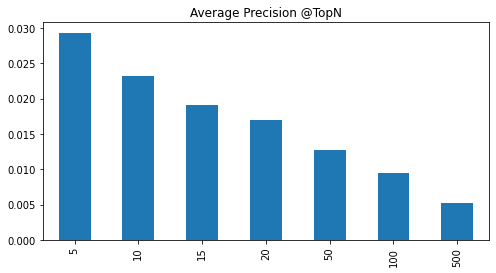

In [93]:
# X: TopN Y:ACC/Precision
plt.rcParams["figure.figsize"] = (8,4)
pd.Series(dict([(k,np.array(v).mean()) for k,v in accs.items()])).sort_index().plot.bar()
plt.title("Average Precision @TopN")


In [575]:
res_cf = pd.Series(dict([(k,np.array(v).mean()) for k,v in accs.items()]))
res_cf

500    0.005272
100    0.009539
50     0.012730
20     0.016927
15     0.019105
10     0.023205
5      0.029344
dtype: float64

In [14]:
pd.Series(dict([(k,np.array(v).mean()) for k,v in accs.items()])).mean()

0.016836628511966704

Text(0.5, 1.0, 'Average Recall @TopN')

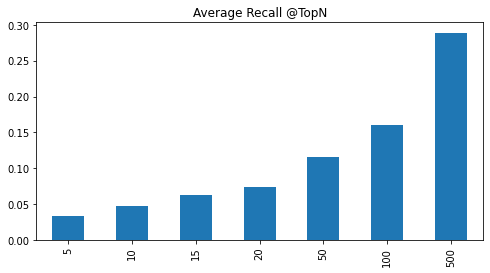

In [12]:
pd.Series(dict([(k,np.array(v).mean()) for k,v in recalls.items()])).sort_index().plot.bar()
plt.title("Average Recall @TopN")

Text(0.5, 1.0, 'Average F1-score @TopN')

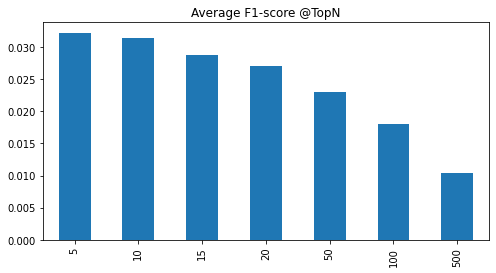

In [118]:
plt.rcParams["figure.figsize"] = (8,4)
rec = np.array([np.array(v).mean() for k,v in recalls.items()])
pre = np.array([np.array(v).mean() for k,v in accs.items()])
f1 = 2* rec * pre /(rec + pre)
pd.Series(f1,accs.keys()).sort_index().plot.bar()
plt.title("Average F1-score @TopN")

In [119]:
# user clusters
clusters = [0, 1, 5, 10, 20, 50, 100, 200, 1469]
user_clusters = {}
for i in range(len(clusters)-1):
    IDs = df.groupby('userID').count()['dummy'].apply(lambda x: x>clusters[i] and x<=clusters[i+1])
    user_clusters[str(clusters[i])+'_'+str(clusters[i+1])] =  list(IDs[IDs==True].index)
for k,v in user_clusters.items():
    print(k+':',len(v))

0_1: 948
1_5: 632
5_10: 170
10_20: 148
20_50: 114
50_100: 49
100_200: 28
200_1469: 24


In [93]:
# # Precision
# def metrics_clusters(f=recommender_precision, res=test_UP,verbose=0):
#   plt.rcParams["figure.figsize"] = (8,4)
#   res_dict = {}
#   for k,v in user_clusters.items():
#     res_dict[k] = f(res.pred[set(v) & set(test_UP.index)], res.true[set(v) & set(test_UP.index)])
#   if verbose == 1:
#     for k,v in res_dict.items():
#       print(k+':',v)
#     print('ALL:',f(res.pred, res.true))
#   pd.Series(res_dict).plot.bar()
# metrics_clusters(verbose=1)

# # metrics_clusters(f=recommender_recall,verbose=1)

500    0.003861
100    0.009251
50     0.012633
20     0.016909
15     0.019077
10     0.023205
5      0.029344
dtype: float64

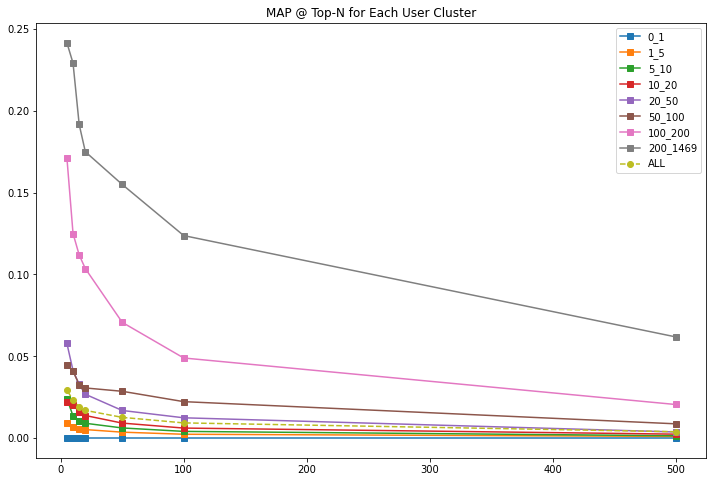

In [355]:
def metrics_map(f=mapk, res=test_UP):
    plt.rcParams["figure.figsize"] = (12,8)
    ks = list(accs.keys()) #[500, 100, 50, 20, 15, 10, 5]
    for _,v in user_clusters.items():
      maps = {}
      v = set(v) & set(df_test.userID)
      for k in ks:
        maps[k] = f(res.true[v],res.pred[v], k=k)
      pd.Series(maps).plot(style='s-')
    map_all = pd.Series([f(res.true,res.pred, k=k) for k in ks])
    map_all.index=ks
    map_all.plot(style='o--')
    legends = list(user_clusters.keys())
    legends.append('ALL')
    plt.legend(legends)
    plt.title(f"MAP @ Top-N for Each User Cluster")
    return map_all
    
metrics_map()

500    0.296377
100    0.157108
50     0.118095
20     0.067800
15     0.058456
10     0.048497
5      0.035611
dtype: float64

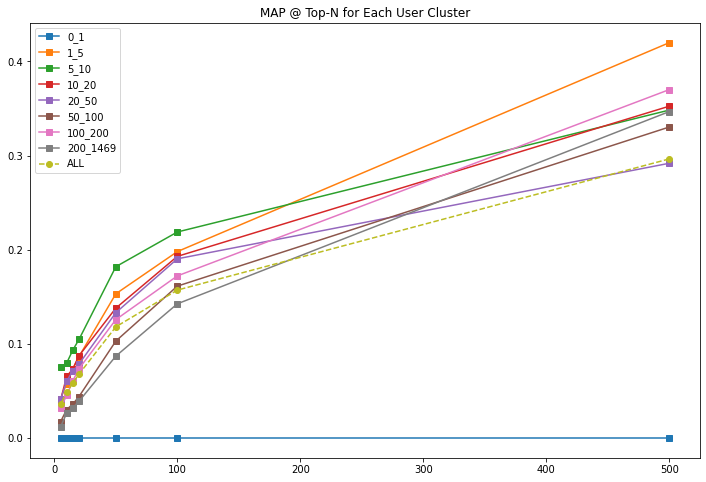

In [356]:
metrics_map(mark)

## BMF
binary df_cf

In [70]:
import nimfa
bmf = nimfa.Bmf(df_cf.values, seed='nndsvd', rank=10, max_iter=12, lambda_w=1.1, lambda_h=1.1)
bmf_fit = bmf()


In [71]:
pd.DataFrame(bmf_fit.fit.W)

,0,1,2,3,4,5,6,7,8,9
0,0.996377,0.781998,0.958247,0.913060,0.965159,0.946144,0.947954,0.974000,0.950520,0.928941
1,0.996941,0.765538,0.956483,0.908678,0.963383,0.944262,0.948014,0.972718,0.945438,0.922479
2,1.002596,0.876723,0.978991,0.981689,0.997261,0.991941,0.981924,0.997550,0.989774,0.980300
3,0.997003,0.754342,0.956949,0.905264,0.962366,0.943110,0.945826,0.972001,0.945003,0.921515
4,0.996745,0.770266,0.959195,0.907380,0.962369,0.945915,0.949174,0.973416,0.948323,0.925286
...,...,...,...,...,...,...,...,...,...,...
1915,0.996550,0.781635,0.960987,0.904944,0.963252,0.947466,0.950985,0.974107,0.950780,0.929283
1916,1.004295,1.065025,1.024523,1.047282,1.025341,1.026815,1.033542,1.012176,1.033761,1.043651
1917,1.015463,1.186762,1.075958,1.081946,1.052169,1.054757,1.061465,1.049763,1.061380,1.063207
1918,0.996575,0.779990,0.957830,0.918961,0.965173,0.950310,0.953751,0.975597,0.953390,0.932809


In [72]:
np.array(bmf_fit.fit.W[1] * bmf_fit.fit.H)[0]

array([0.02012047, 0.00699458, 0.00239051, ..., 0.00052908, 0.00052243,
       0.00059915])

In [73]:
bmf_fit.fit.H.shape

(10, 5462)

In [74]:
res = np.array(bmf_fit.fit.W[1919] * bmf_fit.fit.H)[0]
res

array([0.02396974, 0.00823097, 0.00283626, ..., 0.00060352, 0.00059724,
       0.00070247])

In [75]:
# dict_idp = pd.Series(range(df_cf.shape[1]),df_cf.columns)
# dict_idp[190]

In [346]:
start = time.time()

# import nimfa
bmf = nimfa.Bmf(df_cf.values, seed='nndsvd', rank=10, max_iter=12, lambda_w=1.1, lambda_h=1.1)
bmf_fit = bmf()


# recommend movie for test set users
pred_res = []
accs = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]}
recalls = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]}

for UID in test_UP.index:
    if UID in df_cf.index: #if it is not new user
        index_for_user = df_cf.index.tolist().index(UID)
        UIndex = test_UP.index.get_loc(UID)
        pred_val = np.array(bmf_fit.fit.W[UIndex] * bmf_fit.fit.H)[0]
        cand_P = pd.Series(pred_val, df_cf.columns).sort_values(ascending=False)
        watched = df_train[df_train.userID==UID]['movieID'].tolist()
        cand_P = cand_P[~cand_P.index.isin(watched)] # remove watched movie
        cand_P = cand_P.index.tolist()[:1000] # select max top 1000
    else:
        cand_P = []
#         print(UID, "is new user")
    pred_res.append(cand_P)
#     print(round(len(set(test_UP[UID]) & set(cand_P)) / (len(cand_P)+1e-9),3))
    
    for topN in list(accs.keys()):
        cand_P = cand_P[:topN]
        truth = set(test_UP.loc[UID,'true'])
        acc = round(len(truth & set(cand_P)) / (len(cand_P)+1e-9),3)
        accs[topN].append(acc)
        recall = round(len(truth & set(cand_P)) / (len(truth)+1e-9),3)
        recalls[topN].append(recall)
        
test_UP['pred'] = pred_res
#     print(UID)
#     print(recommender_precision([list(cand_P)],[list(test_UP[UID])]))
#     print(mapk([list(test_UP[UID])],[list(cand_P)], 100))

end = time.time()
print(end-start)

13.788280010223389


Text(0.5, 1.0, 'Average Precision @TopN')

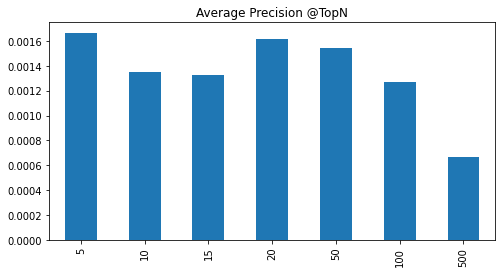

In [77]:
# # X: TopN Y:ACC/Precision
plt.rcParams["figure.figsize"] = (8,4)
pd.Series(dict([(k,np.array(v).mean()) for k,v in accs.items()])).sort_index().plot.bar()
plt.title("Average Precision @TopN")

In [82]:
res_bmf = pd.Series(dict([(k,np.array(v).mean()) for k,v in accs.items()])).sort_index()
res_bmf

5      0.001665
10     0.001353
15     0.001323
20     0.001613
50     0.001540
100    0.001270
500    0.000664
dtype: float64

In [80]:
[(k,np.array(v).mean()) for k,v in accs.items()]

[(500, 0.000663891779396462),
 (100, 0.0012695109261186264),
 (50, 0.0015400624349635795),
 (20, 0.0016129032258064518),
 (15, 0.0013225806451612906),
 (10, 0.0013527575442247662),
 (5, 0.0016649323621227888)]

In [24]:
pd.Series(dict([(k,np.array(v).mean()) for k,v in accs.items()])).mean()

0.0118437639363758

In [ ]:
pd.Series(dict([(k,np.array(v).mean()) for k,v in recalls.items()])).sort_index().plot.bar()
plt.title("Average Recall @TopN")

Text(0.5, 1.0, 'Average F1-score @TopN')

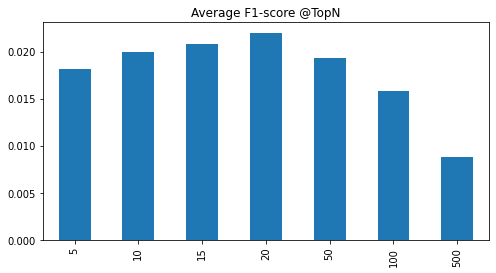

In [304]:
plt.rcParams["figure.figsize"] = (8,4)
rec = np.array([np.array(v).mean() for k,v in recalls.items()])
pre = np.array([np.array(v).mean() for k,v in accs.items()])
f1 = 2* rec * pre /(rec + pre)
pd.Series(f1,accs.keys()).sort_index().plot.bar()
plt.title("Average F1-score @TopN")

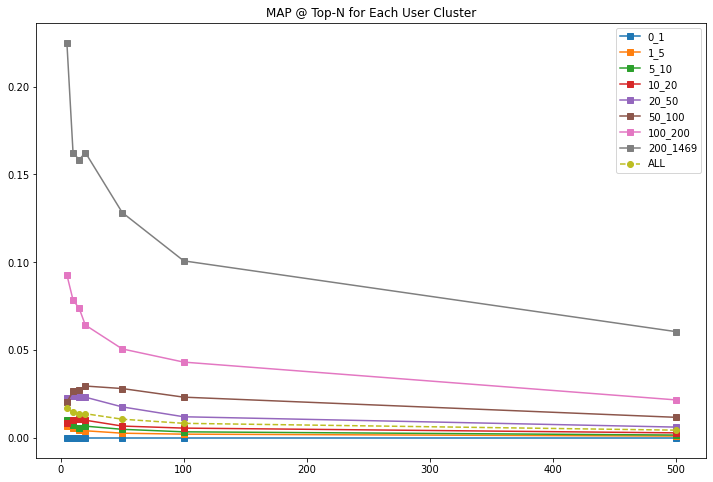

In [309]:
def metrics_map(f=mapk, res=test_UP):
    plt.rcParams["figure.figsize"] = (12,8)
    ks = list(accs.keys()) #[500, 100, 50, 20, 15, 10, 5]
    for _,v in user_clusters.items():
      maps = {}
      v = set(v) & set(df_test.userID)
      for k in ks:
        maps[k] = f(res.true[v],res.pred[v], k=k)
      pd.Series(maps).plot(style='s-')
    map_all = pd.Series([f(res.true,res.pred, k=k) for k in ks])
    map_all.index=ks
    map_all.plot(style='o--')
    legends = list(user_clusters.keys())
    legends.append('ALL')
    plt.legend(legends)
    plt.title(f"MAP @ Top-N for Each User Cluster")
    
metrics_map()

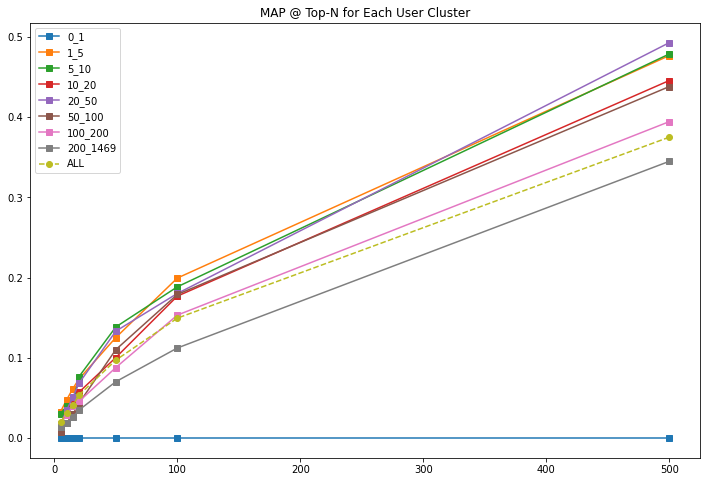

In [310]:
metrics_map(mark)

## NMF

In [95]:
nmf = nimfa.Nmf(df_cf.values, seed="nndsvd", rank=10, max_iter=12, update='euclidean',
                objective='fro')
nmf_fit = nmf()

In [96]:
pd.DataFrame(nmf_fit.fit.W)

,0,1,2,3,4,5,6,7,8,9
0,2.460776e-03,2.220446e-16,7.804238e-09,2.220446e-16,2.220446e-16,2.934617e-03,2.220446e-16,2.220446e-16,2.220446e-16,4.941522e-03
1,2.220446e-16,2.220446e-16,2.220446e-16,1.264359e-14,5.198635e-10,9.306320e-03,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16
2,4.990108e-13,4.400740e-02,2.368090e-03,2.220446e-16,6.235734e-09,1.024841e-01,2.116575e-02,2.220446e-16,2.220446e-16,2.220446e-16
3,2.220446e-16,2.220446e-16,1.618729e-11,6.791213e-13,1.200172e-04,2.220446e-16,8.755131e-05,2.220446e-16,6.616200e-05,2.220446e-16
4,5.348421e-12,1.767260e-03,2.220446e-16,2.220446e-16,2.220446e-16,1.464838e-06,2.220446e-16,2.220446e-16,2.220446e-16,8.068168e-04
...,...,...,...,...,...,...,...,...,...,...
1915,1.101586e-11,4.002734e-03,2.830489e-04,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,2.220446e-16,1.200741e-03
1916,2.352048e-02,1.165315e-13,5.834990e-02,1.393543e-02,1.478784e-01,6.881445e-15,2.220446e-16,6.397757e-02,5.291881e-16,8.273372e-02
1917,8.693963e-02,1.885203e-10,4.162864e-02,4.743301e-16,2.220446e-16,2.220446e-16,1.111576e-02,2.220446e-16,2.220446e-16,1.231313e-02
1918,2.220446e-16,2.220446e-16,2.402723e-03,2.220446e-16,9.221103e-14,3.590894e-03,2.220446e-16,2.220446e-16,2.220446e-16,5.450198e-03


In [349]:
start = time.time()


nmf = nimfa.Nmf(df_cf.values, seed="nndsvd", rank=10, max_iter=12, update='euclidean',
                objective='fro')
nmf_fit = nmf()

# recommend movie for test set users
pred_res = []
accs = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]}
recalls = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]}

for UID in test_UP.index:
    if UID in df_cf.index: #if it is not new user
        index_for_user = df_cf.index.tolist().index(UID)
        UIndex = test_UP.index.get_loc(UID)
        pred_val = np.array(nmf_fit.fit.W[UIndex] * nmf_fit.fit.H)[0]
        cand_P = pd.Series(pred_val, df_cf.columns).sort_values(ascending=False)
        watched = df_train[df_train.userID==UID]['movieID'].tolist()
        cand_P = cand_P[~cand_P.index.isin(watched)] # remove watched movie
        cand_P = cand_P.index.tolist()[:1000] # select max top 1000
    else:
        cand_P = []
#         print(UID, "is new user")
    pred_res.append(cand_P)
#     print(round(len(set(test_UP[UID]) & set(cand_P)) / (len(cand_P)+1e-9),3))
    
    for topN in list(accs.keys()):
        cand_P = cand_P[:topN]
        truth = set(test_UP.loc[UID,'true'])
        acc = round(len(truth & set(cand_P)) / (len(cand_P)+1e-9),3)
        accs[topN].append(acc)
        recall = round(len(truth & set(cand_P)) / (len(truth)+1e-9),3)
        recalls[topN].append(recall)
        
test_UP['pred'] = pred_res
#     print(UID)
#     print(recommender_precision([list(cand_P)],[list(test_UP[UID])]))
#     print(mapk([list(test_UP[UID])],[list(cand_P)], 100))

end = time.time()
print(end-start)

16.277201890945435


Text(0.5, 1.0, 'Average Precision @TopN')

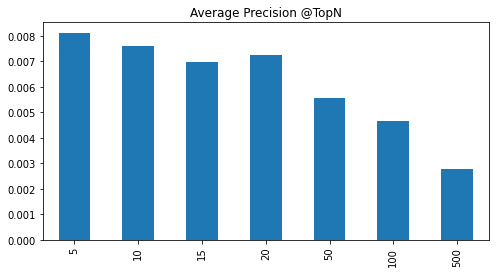

In [98]:
# X: TopN Y:ACC/Precision
plt.rcParams["figure.figsize"] = (8,4)
pd.Series(dict([(k,np.array(v).mean()) for k,v in accs.items()])).sort_index().plot.bar()
plt.title("Average Precision @TopN")

In [99]:
res_nmf = pd.Series(dict([(k,np.array(v).mean()) for k,v in accs.items()])).sort_index()

Text(0.5, 1.0, 'Average F1-score @TopN')

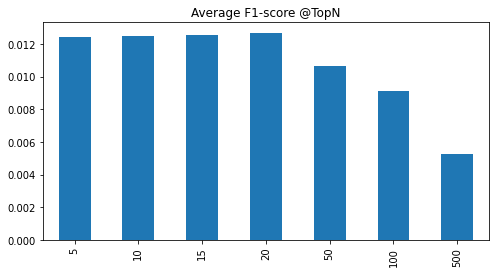

In [329]:


# pd.Series(dict([(k,np.array(v).mean()) for k,v in recalls.items()])).sort_index().plot.bar()
# plt.title("Average Recall @TopN")

plt.rcParams["figure.figsize"] = (8,4)
rec = np.array([np.array(v).mean() for k,v in recalls.items()])
pre = np.array([np.array(v).mean() for k,v in accs.items()])
f1 = 2* rec * pre /(rec + pre)
pd.Series(f1,accs.keys()).sort_index().plot.bar()
plt.title("Average F1-score @TopN")

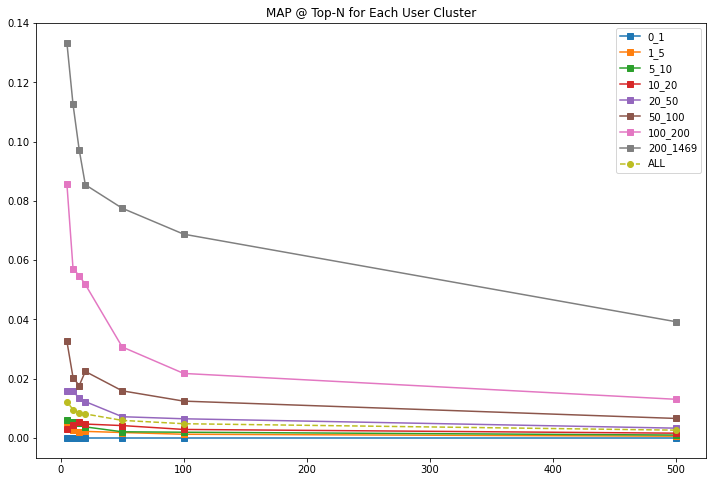

In [330]:
def metrics_map(f=mapk, res=test_UP):
    plt.rcParams["figure.figsize"] = (12,8)
    ks = list(accs.keys()) #[500, 100, 50, 20, 15, 10, 5]
    for _,v in user_clusters.items():
      maps = {}
      v = set(v) & set(df_test.userID)
      for k in ks:
        maps[k] = f(res.true[v],res.pred[v], k=k)
      pd.Series(maps).plot(style='s-')
    map_all = pd.Series([f(res.true,res.pred, k=k) for k in ks])
    map_all.index=ks
    map_all.plot(style='o--')
    legends = list(user_clusters.keys())
    legends.append('ALL')
    plt.legend(legends)
    plt.title(f"MAP @ Top-N for Each User Cluster")
    
metrics_map()

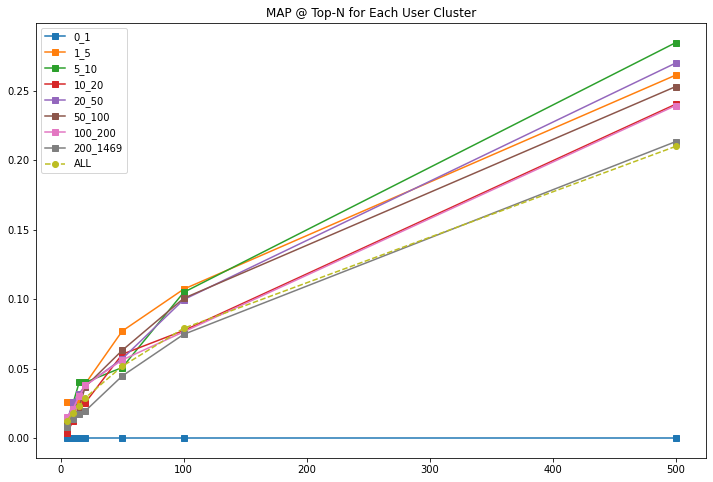

In [331]:
metrics_map(mark)

# Clustering + CF

In [355]:
estimator.predict()

TypeError: predict() missing 1 required positional argument: 'X'

/tmp/ipykernel_3872559/3529316077.py:32: UserWarning: Attempting to set identical left == right == -0.9624160473064598 results in singular transformations; automatically expanding.
  plt.imshow(Z, interpolation='nearest',
/tmp/ipykernel_3872559/3529316077.py:32: UserWarning: Attempting to set identical bottom == top == -0.6739653304401575 results in singular transformations; automatically expanding.
  plt.imshow(Z, interpolation='nearest',


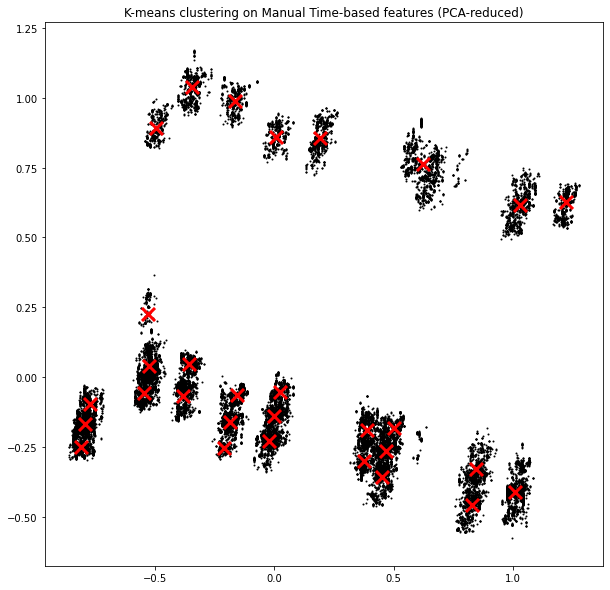

In [350]:
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
scaler = MinMaxScaler()
df_selected = scaler.fit_transform(df_train.filter(regex="[^time_stamp]").iloc[:,3:])
df_selected = pd.DataFrame(df_selected)
df_selected.columns = df_train.filter(regex="[^time_stamp]").iloc[:,3:].columns
vectors = PCA(n_components=2).fit_transform(df_selected) #高维度PCA降维到2维

estimator = KMeans(n_clusters=30,random_state=0)#构造聚类器
estimator.fit(vectors)#聚类
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

# Step size of the mesh. Decrease to increase the quality of the VQ.
h = 100     # point in the mesh [x_min, x_max]x[y_min, y_max].

# Plot the decision boundary. For that, we will assign a color to each
x_min, x_max = vectors[:, 0].min() - 0.1, vectors[:, 0].max() + 0.1
y_min, y_max = vectors[:, 1].min() - 0.1, vectors[:, 1].max() + 0.1
xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

# Obtain labels for each point in mesh. Use last trained model.
Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot
# Z = Z.reshape(xx.shape)
# plt.figure(1)
# plt.clf()
# plt.rcParams["figure.figsize"] = (10, 10)
# plt.imshow(Z, interpolation='nearest',
#            extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#            cmap=plt.cm.Paired,
#            aspect='auto', origin='lower')

plt.plot(vectors[:, 0], vectors[:, 1], 'k.', markersize=2)
# Plot the centroids as a white X
centroids = estimator.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=169, linewidths=3,
            color='red', zorder=10)
plt.title('K-means clustering on Manual Time-based features (PCA-reduced)')

plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
plt.show()


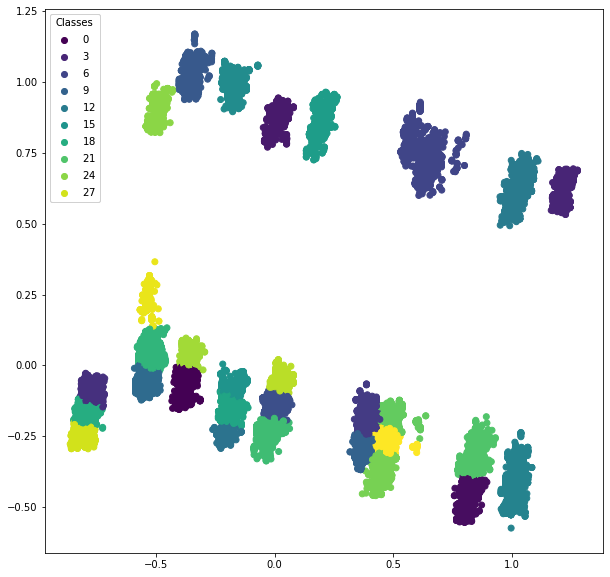

In [351]:
fig, ax =  plt.subplots()
scatter = ax.scatter(vectors[:,0],vectors[:,1], c=label_pred)
legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Classes")
ax.add_artist(legend1)
plt.show()

In [352]:
dict_userLabel = dict(zip(df_train.userID.unique(),estimator.labels_))
df_train.loc[:,'cluster_label'] = [dict_userLabel[i] for i in df_train.userID]
df_train.head()

/home/liu/venv-neu/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


,userID,movieID,tagID,date_day,date_month,date_year,date_hour,date_minute,date_second,timestamps,...,quarter,days_in_month,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_leap_year,cluster_label
46052,70806,2976,4303,24,8,2007,13,22,26,2007-08-24 13:22:26,...,3,31,False,False,False,False,False,False,False,22
308,788,5414,14656,29,8,2007,20,12,35,2007-08-29 20:12:35,...,3,31,False,False,False,False,False,False,False,22
30961,41130,42738,62,20,2,2006,3,52,3,2006-02-20 03:52:03,...,1,28,False,False,False,False,False,False,False,27
471,1436,1994,1595,2,9,2007,18,46,34,2007-09-02 18:46:34,...,3,30,False,False,False,False,False,False,False,29
40377,59771,51662,4342,10,4,2007,0,30,13,2007-04-10 00:30:13,...,2,30,False,False,False,False,False,False,False,17


In [354]:
df_train.cluster_label.value_counts()

18    6087
6     4095
3     2768
13    2693
29    2454
25    1894
10    1405
21    1260
19    1249
0     1210
22    1097
23    1014
17     924
1      921
20     917
12     881
14     860
27     846
15     835
9      780
7      722
4      662
5      649
16     603
8      539
2      295
28     235
26     197
24     178
11      95
Name: cluster_label, dtype: int64

In [368]:
# voting instance to user level
# Top 3
df_tagging = pd.concat([df_train.iloc[:,:3].reset_index(drop=True),pd.Series(label_pred)], axis=1)
df_tagging = df_tagging.rename(columns={0:'cluster'})

# # find users' all clusters
df_userC = df_tagging.groupby(['userID','cluster'])[['movieID']].count()
df_userC = df_userC.rename(columns={'movieID':'count'})
df_userC = df_userC.reset_index().sort_values(by=['userID','count'], ascending=[True,False])

In [369]:
df_userC[df_userC.userID==71509] # count is the frequency of cluster apearing in a user's tagging behaviour

,userID,cluster,count
3493,71509,6,97
3494,71509,21,2
3495,71509,22,1


In [373]:
df_userC.userID.nunique()

1935

In [375]:
# Use voting to assign Top3 clusters to user
df_userC_Top = pd.DataFrame(df_userC.groupby('userID').apply(lambda x: x['cluster'][:3])).reset_index() # MAX 3 clusters orig 3743-> 2933 (Top3)
del df_userC_Top['level_1']
df_userC_Top

,userID,cluster
0,75,21
1,127,29
2,170,1
3,175,21
4,175,29
...,...,...
2690,71509,21
2691,71509,22
2692,71525,20
2693,71529,1


In [388]:
dict_UC = df_userC_Top.groupby('userID').apply(lambda x: list(x['cluster']))
dict_CU =df_userC_Top.groupby('cluster').apply(lambda x: list(x['userID']))

In [389]:
df_userC_Top.cluster.value_counts() # cluster对于user的分组

19    179
10    166
6     142
13    139
18    127
12    126
20    121
0     120
21    120
29    118
27    115
23    109
1     104
7     100
17     95
16     84
5      75
22     75
9      71
8      60
2      59
14     58
25     58
4      57
3      51
24     51
11     39
15     31
26     30
28     15
Name: cluster, dtype: int64

# Hashing + CF

In [583]:
from mylsh import * 
# 重新run df 不加dummy, 重新split

## Aggreation hashing
mean

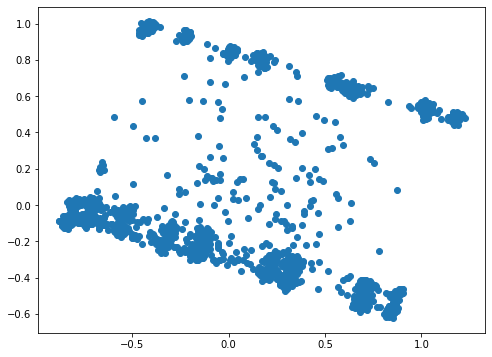

In [381]:
# Aggregated on user level
df_selected = df_train.filter(regex="[^time_stamp]")
df_selected = df_selected.iloc[:,3:]
cols = df_selected.columns

scaler = MinMaxScaler()
df_selected = scaler.fit_transform(df_selected)
df_selected = pd.DataFrame(df_selected)
df_selected = pd.concat([df_train.iloc[:,:3].reset_index(drop=True),df_selected.reset_index(drop=True)], axis=1)

# Mean/Median aggreation
df_user = df_selected.groupby('userID').mean().iloc[:,2:]
vectors = PCA().fit_transform(df_user) 
plt.rcParams["figure.figsize"] = (8, 6)
plt.scatter(vectors[:,0],vectors[:,1])

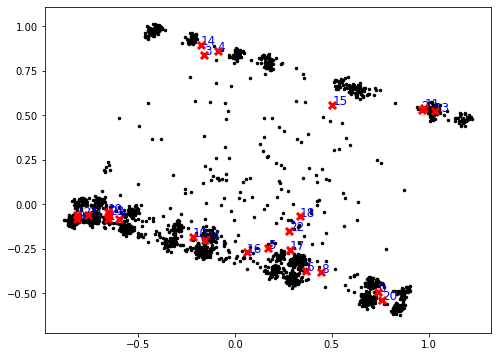

In [6]:
CLUSTERS = 25
# need to remove original cols first, only keep pca vec
estimator = KMeans(n_clusters=CLUSTERS,random_state=0)#构造聚类器
estimator.fit(vectors)#聚类 输入vectors 或者原始df_user
label_pred = estimator.labels_ #获取聚类标签
centroids = estimator.cluster_centers_ #获取聚类中心
inertia = estimator.inertia_ # 获取聚类准则的总和

x_min, x_max = vectors[:, 0].min() - 0.1, vectors[:, 0].max() + 0.1
y_min, y_max = vectors[:, 1].min() - 0.1, vectors[:, 1].max() + 0.1

plt.rcParams["figure.figsize"] = (8, 6)

plt.plot(vectors[:, 0], vectors[:, 1], 'k.', markersize=5)
# Plot the centroids as a white X
centroids = estimator.cluster_centers_
plt.scatter(centroids[:, 0], centroids[:, 1],
            marker='x', s=50, linewidths=3,
            color='red', zorder=10)
# plt.title('K-means clustering on the TSFresh Features (PCA-reduced data)\n'
#           'Centroids are marked with white cross')
for i in range(CLUSTERS):
    plt.text(centroids[i, 0], centroids[i, 1], i, color='blue',size='large')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
# plt.xticks(())
# plt.yticks(())
plt.show()


In [7]:
pd.Series(label_pred).value_counts()

16    155
8     118
10    112
5     110
19    108
7     106
0      93
15     93
6      89
1      89
24     84
23     81
14     72
12     72
3      70
20     70
4      69
21     65
2      59
11     52
9      49
13     48
17     31
22     25
18     15
dtype: int64

In [248]:
## Hyperplane-LSH
start = time.time()
vectors = pd.DataFrame(vectors)

df_user = df_user.reset_index(drop=True)
corpus_u = sframe_to_scipy(df_user)  # use df_user or PCA-vectors
model_u = train_lsh(corpus_u, 16, seed=0)

end = time.time()
print(end-start)

0.012163400650024414


In [9]:
pd.Series([''.join(str(i)) for i in np.array(model_u['bin_indices_bits'],dtype=int)]).value_counts() #  16-bit

[1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1]    129
[1 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1]    118
[1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1]     79
[1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1]     67
[1 1 0 1 1 0 1 1 1 0 0 1 1 1 0 1]     66
                                    ... 
[0 1 0 1 0 0 1 1 0 0 0 0 1 1 0 1]      1
[1 1 0 1 0 1 0 1 0 0 0 1 1 0 0 0]      1
[1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0]      1
[1 0 0 1 0 1 1 1 1 0 1 1 0 1 0 1]      1
[1 1 0 1 1 1 1 1 0 1 0 1 1 0 0 0]      1
Length: 301, dtype: int64

In [10]:
pd.Series(model_u['bin_indices']).value_counts().value_counts()

1      133
2       42
3       22
4       22
6       14
7       11
5        9
8        5
9        4
15       3
10       3
11       3
21       2
23       2
13       2
12       2
14       1
41       1
118      1
79       1
67       1
66       1
57       1
55       1
53       1
49       1
44       1
34       1
18       1
33       1
31       1
30       1
28       1
27       1
24       1
20       1
19       1
129      1
dtype: int64

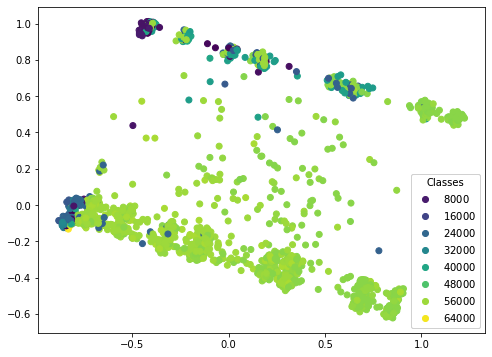

In [11]:
fig, ax =  plt.subplots()
scatter = ax.scatter(vectors[0],vectors[1], c=model_u['bin_indices'])
legend1 = ax.legend(*scatter.legend_elements(), loc="best", title="Classes")
ax.add_artist(legend1)
plt.show()

<AxesSubplot:ylabel='Frequency'>

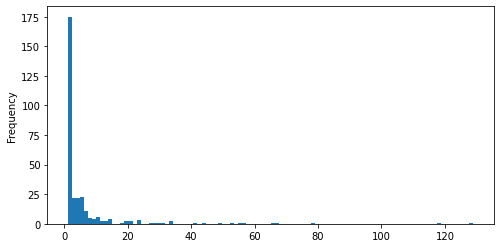

In [12]:
plt.rcParams["figure.figsize"] = (8, 4)
pd.Series(model_u['bin_indices']).value_counts().plot.hist(bins=100)

## Vote hashing

In [18]:
corpus_u = sframe_to_scipy(df_selected.iloc[:,3:])  # use df_user or PCA-vectors
model_u = train_lsh(corpus_u, 16, seed=0)
pd.Series([''.join(str(i)) for i in np.array(model_u['bin_indices_bits'],dtype=int)]).value_counts() #  16-bit

[1 1 0 1 0 0 1 1 1 0 0 1 1 1 0 1]    1669
[1 1 0 1 1 0 1 1 0 0 0 1 1 1 0 1]    1651
[1 1 0 1 0 1 1 1 1 0 0 1 1 1 0 1]    1358
[1 1 0 1 0 0 1 1 1 0 0 0 1 1 0 1]    1337
[0 1 0 1 1 0 1 1 0 1 0 1 1 1 1 1]    1201
                                     ... 
[0 1 0 0 1 1 1 1 0 1 0 1 1 1 0 0]       1
[1 1 0 1 1 0 1 1 0 0 1 1 1 1 0 1]       1
[1 1 1 1 1 0 1 0 0 0 1 1 1 1 0 1]       1
[0 0 0 1 1 0 1 1 0 1 0 1 0 0 0 0]       1
[1 0 1 1 1 0 1 0 0 0 0 1 1 1 0 1]       1
Length: 781, dtype: int64

<AxesSubplot:ylabel='Frequency'>

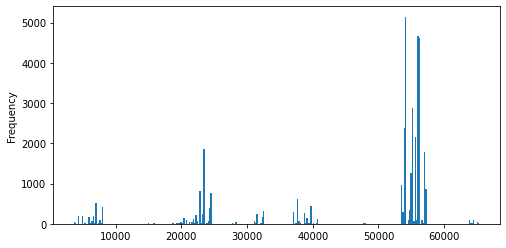

In [19]:
plt.rcParams["figure.figsize"] = (8, 4)
pd.Series(model_u['bin_indices']).plot.hist(bins=300)

<AxesSubplot:ylabel='Frequency'>

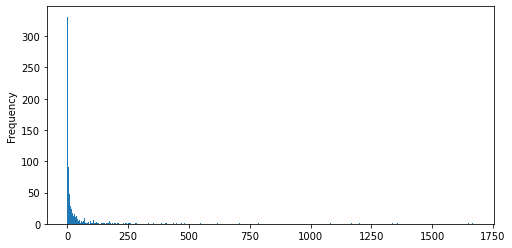

In [35]:
plt.rcParams["figure.figsize"] = (8, 4)
pd.Series(model_u['bin_indices']).value_counts().plot.hist(bins=500)

In [53]:
pd.Series(model_u['bin_indices']).value_counts().value_counts() # 154个1， 最大类1669

1      154
2       84
4       49
3       44
5       35
      ... 
121      1
117      1
115      1
110      1
334      1
Length: 151, dtype: int64

In [36]:
df_selected['bucket'] = model_u['bin_indices']
df_selected

,userID,movieID,tagID,0,1,2,3,4,5,6,...,8,9,10,11,12,13,14,15,16,bucket
0,70806,2976,4303,0.766667,0.636364,0.50,0.565217,0.372881,0.440678,0.666667,...,0.666667,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56093
1,788,5414,14656,0.933333,0.636364,0.50,0.869565,0.203390,0.593220,0.333333,...,0.666667,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,56093
2,41130,42738,62,0.633333,0.090909,0.25,0.130435,0.881356,0.050847,0.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,39825
3,1436,1994,1595,0.033333,0.727273,0.50,0.782609,0.779661,0.576271,1.000000,...,0.666667,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54157
4,59771,51662,4342,0.300000,0.272727,0.50,0.000000,0.508475,0.220339,0.166667,...,0.333333,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,55193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38360,21767,1502,5231,0.200000,0.090909,0.75,0.173913,0.101695,0.186441,0.500000,...,0.000000,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,6428
38361,68986,170,35,0.700000,1.000000,0.25,0.434783,0.169492,0.491525,0.666667,...,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54173
38362,55840,2791,605,0.133333,0.090909,0.25,0.304348,0.559322,0.745763,1.000000,...,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,19295
38363,2429,358,1576,0.766667,1.000000,0.25,0.913043,0.830508,0.423729,1.000000,...,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,54157


In [37]:
df_selected.bucket.nunique()

781

In [38]:
df_ub = pd.DataFrame(df_selected.groupby('userID').apply(lambda x: list(x['bucket'])))
df_ub.columns = ['buckets']
df_ub['len_b'] = df_ub.buckets.apply(len)
df_ub['vote_b'] = df_ub.buckets.apply(lambda x: max(set(x), key=x.count)) # use mode as voting results
df_ub['sum_b'] = df_ub.buckets.apply(sum) #继续求mod, 取前两位等等
df_ub['mean_b'] = df_ub.buckets.apply(np.mean).astype(int)
df_ub

,buckets,len_b,vote_b,sum_b,mean_b
userID,,,,,
75,[56205],1,56205,56205,56205
127,"[54173, 57245, 55197, 57245, 54169, 57245, 551...",20,57245,1115196,55759
170,[55189],1,55189,55189,55189
175,"[54173, 56093]",2,56093,110266,55133
190,"[55477, 24413, 55477, 23444, 23444, 55477, 554...",23,55477,1000379,43494
...,...,...,...,...,...
71497,"[54173, 56221, 54173, 54173, 54173, 54169, 541...",33,54173,1811981,54908
71509,"[22328, 22328, 22328, 22300, 22328, 22328, 223...",100,22328,2020363,20203
71525,[56207],1,56207,56207,56207


In [39]:
df_ub.len_b.nunique(), df_ub.vote_b.nunique(), df_ub.sum_b.nunique(), df_ub.mean_b.nunique()

(132, 323, 1284, 1093)

In [56]:
df_ub.len_b.value_counts()#长度，多数为2个记录， 最多一人快800条

1      796
2      243
3      155
4      114
5       76
      ... 
141      1
142      1
143      1
145      1
952      1
Name: len_b, Length: 132, dtype: int64

<AxesSubplot:ylabel='Frequency'>

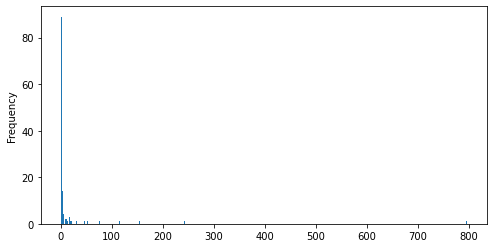

In [64]:
df_ub.groupby('len_b').count()['buckets'].plot.hist(bins=500)

In [63]:
df_ub.len_b.value_counts().value_counts()

1      65
2      24
3       7
4       7
5       4
14      2
15      2
17      2
6       2
11      1
796     1
155     1
114     1
76      1
53      1
46      1
30      1
23      1
12      1
21      1
19      1
18      1
9       1
10      1
13      1
243     1
Name: len_b, dtype: int64

<AxesSubplot:ylabel='Frequency'>

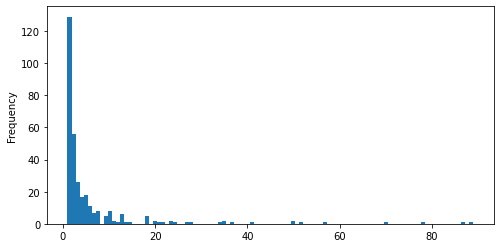

In [68]:
df_ub.groupby('vote_b').count()['buckets'].plot.hist(bins=100) #129个1人组， 最大组有89个用户

In [66]:
df_ub.groupby('vote_b').count()['buckets'].value_counts()

1     129
2      56
3      26
5      18
4      17
6      11
10      8
8       8
7       7
13      6
18      5
9       5
11      2
35      2
20      2
23      2
50      2
87      1
78      1
70      1
57      1
52      1
41      1
37      1
21      1
34      1
28      1
27      1
24      1
22      1
15      1
14      1
12      1
89      1
Name: buckets, dtype: int64

<AxesSubplot:ylabel='Frequency'>

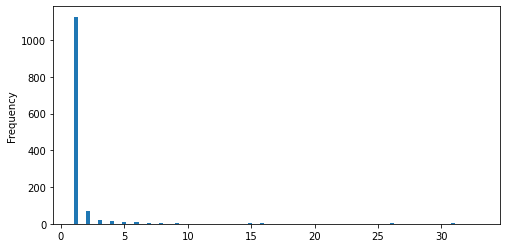

In [67]:
df_ub.groupby('sum_b').count()['buckets'].plot.hist(bins=100) # 1128个1人组，最大组33人

In [62]:
df_ub.groupby('sum_b').count()['buckets'].value_counts()

1     1128
2       68
3       22
4       14
5       12
6       10
8        6
7        5
16       4
9        2
31       2
26       2
15       2
18       1
23       1
11       1
13       1
12       1
10       1
33       1
Name: buckets, dtype: int64

<AxesSubplot:ylabel='Frequency'>

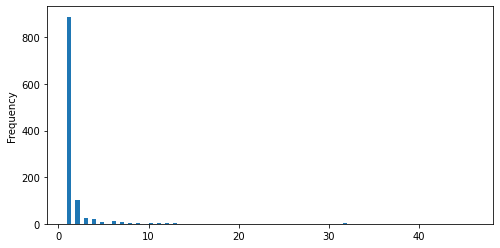

In [69]:
df_ub.groupby('mean_b').count()['buckets'].plot.hist(bins=100) # mean, 889个1人类，最大类43人 

In [67]:
df_ub.groupby('mean_b').count()['buckets'].value_counts()

1     889
2     103
3      27
4      19
6      11
5       8
7       6
8       5
11      3
13      2
32      2
10      2
12      2
9       2
23      1
43      1
36      1
28      1
25      1
15      1
22      1
20      1
19      1
17      1
16      1
46      1
Name: buckets, dtype: int64

# Metapath 切割大bucket

## Agg hash

In [249]:
# start = time.time()
df_user['bucket'] = model_u['bin_indices']
df_user['UID'] =  df_selected.groupby('userID').mean().index
df_user
# end = time.time()
# print(end-start)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,bucket,UID
0,0.933333,0.818182,0.250000,1.000000,0.338983,0.254237,1.000000,0.823529,1.000000,1.000000,0.00,0.000000,0.00,0.000000,0.0,0.0,0.000000,56205,75
1,0.900000,0.636364,0.500000,0.130435,0.736441,0.605085,0.166667,0.666667,0.666667,1.000000,0.00,0.000000,0.00,0.000000,0.0,0.0,0.000000,57245,127
2,0.966667,0.818182,0.250000,0.521739,0.881356,0.949153,0.000000,0.843137,1.000000,1.000000,0.00,0.000000,0.00,0.000000,0.0,0.0,0.000000,55189,170
3,0.816667,0.727273,0.500000,0.521739,0.381356,0.449153,0.750000,0.735294,0.833333,1.000000,0.00,0.000000,0.00,0.000000,0.0,0.0,0.000000,56221,175
4,0.775362,0.335968,0.315217,0.922495,0.616065,0.389094,0.536232,0.367434,0.246377,0.492754,0.00,0.608696,0.00,0.608696,0.0,0.0,0.130435,56213,190
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1930,0.902020,0.639118,0.500000,0.836627,0.554186,0.516179,0.191919,0.669043,0.666667,0.989899,0.00,0.030303,0.00,0.030303,0.0,0.0,0.000000,54173,71497
1931,0.021333,0.566364,0.737500,0.923043,0.577966,0.443390,0.196667,0.530784,0.673333,0.973333,0.87,0.000000,0.87,0.000000,0.0,0.0,0.970000,22328,71509
1932,0.333333,0.454545,0.250000,0.608696,0.915254,0.322034,1.000000,0.431373,0.333333,0.666667,0.00,0.000000,0.00,0.000000,0.0,0.0,0.000000,56207,71525
1933,0.933333,0.818182,0.250000,0.260870,0.203390,0.440678,1.000000,0.823529,1.000000,1.000000,0.00,0.000000,0.00,0.000000,0.0,0.0,0.000000,56223,71529


In [250]:
df_user.bucket.nunique()

301

In [293]:
# use set() to select unique items
# or use list() to get full items#

# start = time.time()
dict_UP = dict(df_selected.iloc[:,:3].groupby('userID').apply(lambda x: set(x['movieID']))) #1935
dict_PU = df_selected.iloc[:,:3].groupby('movieID').apply(lambda x: set(x['userID'])) # 5573
dict_UB = pd.Series(list(df_user.bucket), list(df_user.UID))
dict_BU = df_user.groupby('bucket').apply(lambda x: list(x['UID']))
len(dict_UP),len(dict_UB),len(dict_PU),len(dict_BU)
# end = time.time()
# print(end-start)

(1935, 1935, 5573, 301)

<AxesSubplot:ylabel='Frequency'>

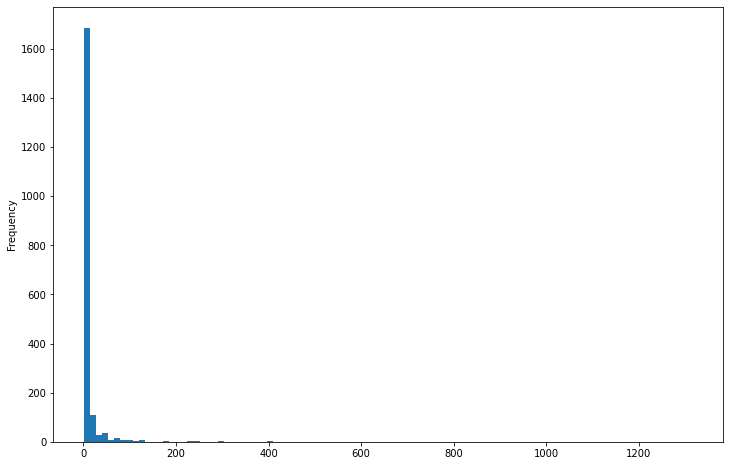

In [232]:
pd.Series([len(dict_UP[u]) for u in df_user.UID]).plot.hist(bins=100)

In [307]:
# start = time.time()
# split big bucket, remain small bucket
bg_bucket, sm_bucket =  [],[]
dict_uu, dict_uulen = {},{}
for k,v in pd.Series(model_u['bin_indices']).value_counts().items():
    if v > 10:
        bg_bucket.append(k)
        U_bucket = list(df_user[df_user.bucket==k].UID)  # for each big bucket
        
        for UID in U_bucket:    # for each user in that big bucket
        #     UP = dict_UP[UID]         #   get all associate product of that user
            U_cand = set()
            for P in dict_UP[UID]:    #   for each associated product 
                U_cand = U_cand | dict_PU[P]           # find users who were related to that product
        #     print(len(U_cand))
            U_new_group = set(U_bucket).intersection(U_cand) #  filter users only in the big bucket #可以扩展为和相似bucket交集
            U_new_group.remove(UID)
            dict_uu[UID] = U_new_group  # 得到新的u-{u...} 对应关系
        #     print(UID, U_new_group)
            new_group_len = len(U_new_group)
            dict_uulen[UID] = new_group_len
        #     print(UID,new_group_len)
        #     df_user[df_user.bucket==UID].replace(UID, f'{UID}n',inplace=True) #不替换原有bucket，从U->B后，再在dict_UU里查找是否存在，若有再细分
            dict_BU[k] = set(dict_BU[k]) - U_new_group # 删除big bucket中已经找到uu关系的用户
    else:
        sm_bucket.append(k)
# end = time.time()
# print(end-start)

In [308]:
len(bg_bucket),len(sm_bucket)

(36, 265)

In [295]:
len(dict_BU[56093])

129

In [299]:
for i in dict_uu[1278]:
    if 6393 in dict_BU[56093]:
        print(0)
    else:
        print(1)

0
0
0
0
0


In [296]:
dict_uu

{1224: {6393,
  11744,
  11898,
  12554,
  18666,
  23172,
  33384,
  39935,
  52806,
  59092,
  65851,
  70974},
 1278: {11898, 29442, 33384, 55762, 69820}}

In [292]:
dict_BU[56093]

{7711, 10844, 38722, 40101, 51673, 52364, 58613}

In [290]:
# U_bucket = df_user[df_user.bucket==56093].UID  # for each big bucket
# dict_uu, dict_uulen = {},{}
# for UID in list(U_bucket)[:2]:    # for each user in that big bucket
#     print('UID',UID)
#     U_cand = set()
#     for P in dict_UP[UID]:    #   for each associated product 
#         U_cand = U_cand | dict_PU[P]           # find users who were related to that product
# #     print(len(U_cand))
#     U_new_group = set(U_bucket).intersection(U_cand) #  filter users only in the big bucket #可以扩展为和相似bucket交集
#     U_new_group.remove(UID)
#     print(len(U_new_group))

#     dict_uu[UID] = U_new_group  # 得到新的u-{u...} 对应关系
# #     print(UID, U_new_group)
#     new_group_len = len(U_new_group)
#     dict_uulen[UID] = new_group_len
# #     print(UID,new_group_len)
# #     df_user[df_user.bucket==56093].replace(UID, f'{UID}n',inplace=True) #不替换，从U->B后，直接在dict_UU里查找是否存在，若有再细分
#     print(U_new_group)
# #     dict_BU[k] = set(dict_BU[k]) - U_new_group # 删除big bucket中已经找到uu关系的用户


    

UID 1224
12
{11744, 23172, 52806, 33384, 12554, 18666, 59092, 6393, 11898, 65851, 70974, 39935}
UID 1278
5
{29442, 33384, 55762, 11898, 69820}


In [255]:
len(dict_uu)

1252

<AxesSubplot:ylabel='Frequency'>

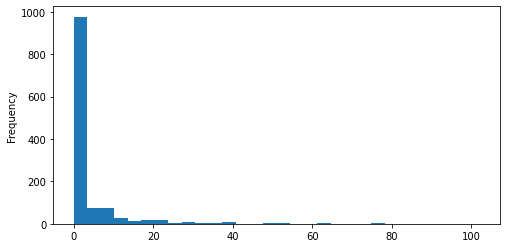

In [256]:
plt.rcParams["figure.figsize"] = (8,4)
pd.Series(dict_uulen).plot.hist(bins=30)

In [238]:
test_UP

,true
userID,
78,[4223]
127,"[2080, 2953, 5679]"
190,"[26662, 5146, 5690]"
383,[6270]
477,"[1608, 2023, 1597]"
...,...
71483,[41617]
71497,"[356, 1682, 54259, 1682, 1197, 261, 1682, 858]"
71509,"[26350, 3702, 5013, 4334, 7925, 2066, 1263, 26..."


In [257]:
df_user[df_user.bucket==55582]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,bucket,UID
117,0.633333,0.545455,0.75,0.565217,0.432203,0.652542,1.000000,0.549020,0.666667,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55582,4335
127,0.866667,0.272727,0.75,0.782609,0.661017,0.000000,1.000000,0.313725,0.333333,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55582,4800
1245,0.733333,0.181818,0.75,0.130435,0.406780,0.355932,1.000000,0.215686,0.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55582,46272
1451,0.400000,0.272727,0.75,0.000000,0.629540,0.438257,1.000000,0.274510,0.333333,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55582,54087
1476,0.600000,0.272727,0.75,0.521739,0.419492,0.487288,0.833333,0.294118,0.333333,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55582,55193
1617,0.700000,0.454545,0.75,0.434783,0.186441,0.423729,1.000000,0.470588,0.333333,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55582,60195
1688,0.800000,0.363636,0.75,0.652174,0.508475,0.610169,1.000000,0.392157,0.333333,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55582,62795
1861,0.700000,0.454545,0.75,0.695652,0.403955,0.375706,1.000000,0.470588,0.333333,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55582,69232
1883,0.866667,0.454545,0.75,0.086957,0.237288,0.254237,0.666667,0.490196,0.333333,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,1.0,55582,70062


In [258]:
U_cand_B

{19714, 25867, 26819, 56281, 59355, 62787, 64364, 64515, 64854, 69245, 71307}

In [260]:
dict_UB[127]

57245

In [261]:
dict_BU[57245]

{19714, 25867, 26819, 56281, 59355, 62787, 64364, 64515, 64854, 69245, 71307}

In [303]:
U_cand

{1278,
 1632,
 2643,
 7612,
 8683,
 11898,
 21838,
 22936,
 23388,
 24221,
 26048,
 29442,
 29892,
 33384,
 33477,
 39677,
 45286,
 45290,
 47448,
 48006,
 55762,
 59771,
 69820,
 70116}

In [330]:
# recommend movie for test set users
pred_res = []
accs = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]} # top 500-5, each list contains acc of all users
recalls = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]}

for UID in test_UP.index:
    if UID in dict_UB.keys(): #if it is not new user
#         print('UID',UID)
        if UID in dict_uu.keys():            
            U_cand = list(dict_uu[UID])
        else:
            U_cand = [] # need to empty this array, since some of user have no uu candidates
#         print(len(U_cand))
        U_cand_B = set(dict_BU[dict_UB[UID]])
#         U_cand_B.remove(UID)
        U_cand_B = list(U_cand_B)
#         print(len(U_cand_B))
        
        U_cand.extend(U_cand_B)
#         print(len(U_cand))
        U_cand = U_cand[:100] # combine 2 cand, only keep 100 sim users
        
        P_cand = set()
        for u in U_cand:
            P_cand = P_cand | dict_UP[u]
        P_cand = list(P_cand)[:500]  #select max top 500 
        
    else:
        P_cand = []
#         print(UID, "is new user")
    pred_res.append(P_cand)
#     print(round(len(set(test_UP[UID]) & set(cand_P)) / (len(cand_P)+1e-9),3))
    
    truth = set(test_UP.loc[UID,'true'])
    for topN in list(accs.keys()):
        P_cand = P_cand[:topN]

        acc = round(len(truth & set(P_cand)) / (len(P_cand)+1e-99),10)
        accs[topN].append(acc)
        recall = round(len(truth & set(P_cand)) / (len(truth)+1e-99),10)
        recalls[topN].append(recall)
        
test_UP['pred'] = pred_res

#     print(UID)
#     print(recommender_precision([list(cand_P)],[list(test_UP[UID])]))
#     print(mapk([list(test_UP[UID])],[list(cand_P)], 100))

### Evaluation

Text(0.5, 1.0, 'Average Precision @TopN')

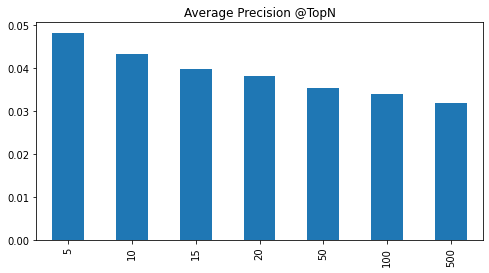

In [706]:
# # X: TopN Y:ACC/Precision
plt.rcParams["figure.figsize"] = (8,4)
pd.Series(dict([(k,np.array(v).mean()) for k,v in accs.items()])).sort_index().plot.bar()
plt.title("Average Precision @TopN")

In [710]:
res_hcf = pd.Series(dict([(k,np.array(v).mean()) for k,v in accs.items()])).sort_index()
res_hcf

5      0.048146
10     0.043317
15     0.039753
20     0.038143
50     0.035276
100    0.034006
500    0.031895
dtype: float64

Text(0.5, 1.0, 'Average F1-score @TopN')

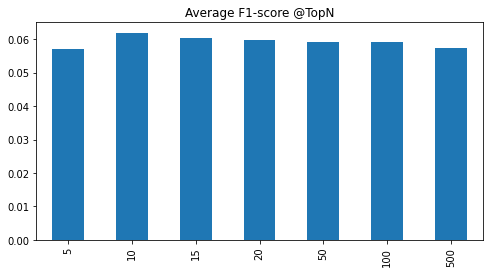

In [711]:
plt.rcParams["figure.figsize"] = (8,4)
rec = np.array([np.array(v).mean() for k,v in recalls.items()])
pre = np.array([np.array(v).mean() for k,v in accs.items()])
f1 = 2* rec * pre /(rec + pre)
pd.Series(f1,accs.keys()).sort_index().plot.bar()
plt.title("Average F1-score @TopN")

In [715]:
clusters = [0, 1, 5, 10, 20, 50, 100, 200, 1469]
user_clusters = {}
for i in range(len(clusters)-1):
    IDs = df.groupby('userID').count()['dummy'].apply(lambda x: x>clusters[i] and x<=clusters[i+1])
    user_clusters[str(clusters[i])+'_'+str(clusters[i+1])] =  list(IDs[IDs==True].index)
for k,v in user_clusters.items():
    print(k+':',len(v))

0_1: 948
1_5: 632
5_10: 170
10_20: 148
20_50: 114
50_100: 49
100_200: 28
200_1469: 24


500    0.031895
100    0.034006
50     0.035276
20     0.038143
15     0.039753
10     0.043317
5      0.048146
dtype: float64

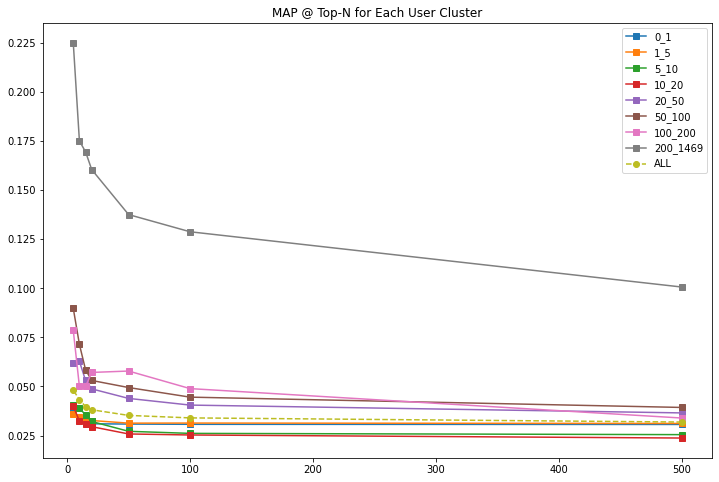

In [716]:
def metrics_map(f=mapk, res=test_UP):
    plt.rcParams["figure.figsize"] = (12,8)
    ks = list(accs.keys()) #[500, 100, 50, 20, 15, 10, 5]
    for _,v in user_clusters.items():
      maps = {}
      v = set(v) & set(df_test.userID)
      for k in ks:
        maps[k] = f(res.true[v],res.pred[v], k=k)
      pd.Series(maps).plot(style='s-')
    map_all = pd.Series([f(res.true,res.pred, k=k) for k in ks])
    map_all.index=ks
    map_all.plot(style='o--')
    legends = list(user_clusters.keys())
    legends.append('ALL')
    plt.legend(legends)
    plt.title(f"MAP @ Top-N for Each User Cluster")
    return map_all
    
metrics_map() # all user-clusters, 

500    0.265446
100    0.209427
50     0.172259
20     0.128638
15     0.115430
10     0.100056
5      0.065079
dtype: float64

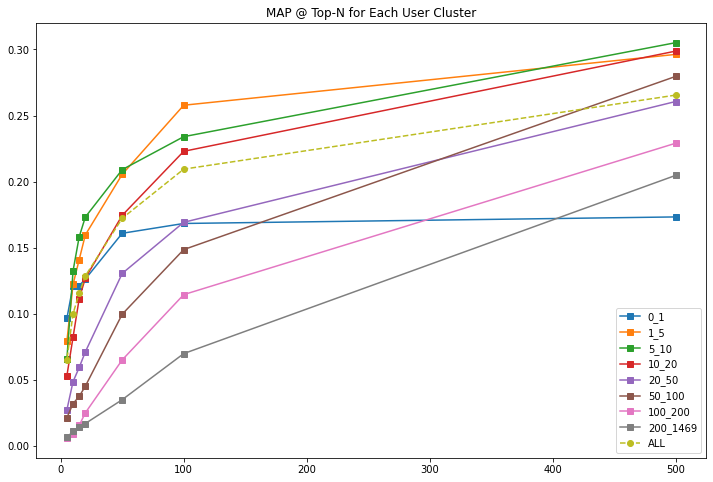

In [717]:
metrics_map(mark) # RECALL

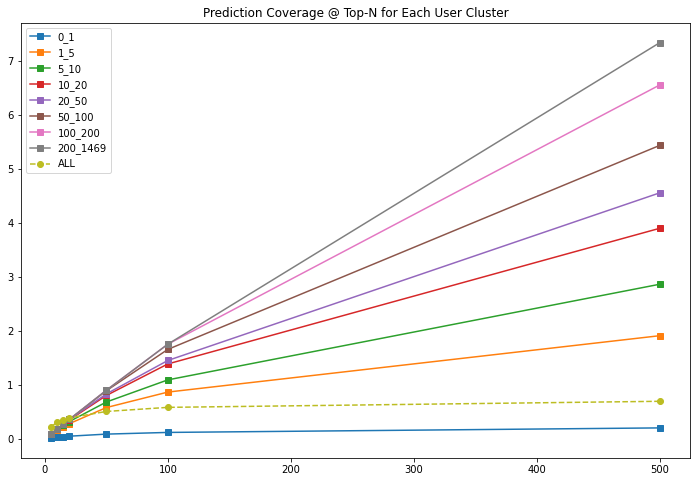

In [718]:
def metrics_cov(f=prediction_coverage, res=test_UP, train = df_train):
    plt.rcParams["figure.figsize"] = (12,8)
    ks = list(accs.keys()) #[500, 100, 50, 20, 15, 10, 5]
    for _,v in user_clusters.items():
      maps = {}
      v = set(v) & set(df_test.userID)
      for k in ks:
        maps[k] =  f(res.pred[v], catalog=train.movieID.unique(), k=k)
      pd.Series(maps).plot(style='s-')
    map_all = pd.Series([f(res.true,res.pred, k=k) for k in ks])
    map_all.index=ks
    map_all.plot(style='o--')
    legends = list(user_clusters.keys())
    legends.append('ALL')
    plt.legend(legends)
    plt.title(f"Prediction Coverage @ Top-N for Each User Cluster")
    
metrics_cov()

In [719]:
def novelty(predicted, pop, u, n):
    mean_self_information = []
    k = 0
    for sublist in predicted:
        self_information = 0
        k += 1
        if len(sublist) > 0:
            for i in sublist:
                if i in pop.keys():
                    self_information += np.sum(-np.log2(pop[i]) /u)
            mean_self_information.append(self_information/n)
        else:
            mean_self_information.append(0)
    novelty = sum(mean_self_information)/k
    return novelty, mean_self_information

ks = [5,10,15,20,25,30,50,100]
for k in ks:
    pop_dict = dict(df_train.movieID.value_counts())
    print(novelty(test_UP.pred, pop_dict, len(df_train.userID.unique()), n=k)[0])

-0.056431160103321956
-0.028215580051660978
-0.018810386701107382
-0.014107790025830489
-0.011286232020664415
-0.009405193350553691
-0.005643116010332207
-0.0028215580051661037


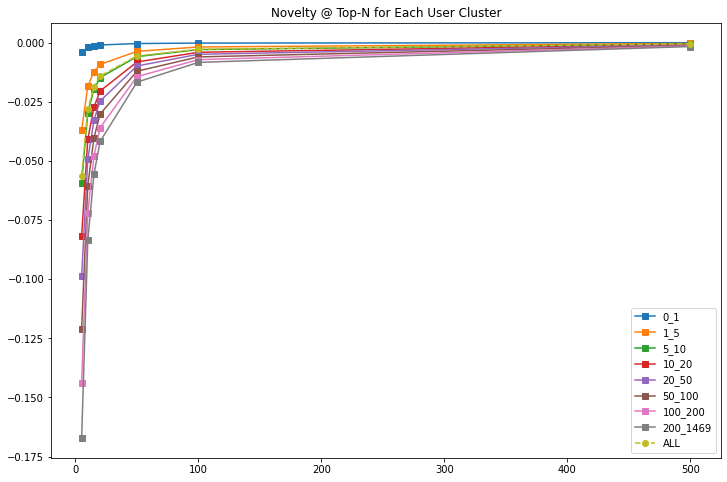

In [720]:
def metrics_nov(f=novelty, res=test_UP, train = df_train):
    plt.rcParams["figure.figsize"] = (12,8)
    ks = list(accs.keys()) #[500, 100, 50, 20, 15, 10, 5]
    pop_dict = dict(train.movieID.value_counts())
    for _,v in user_clusters.items():
      maps = {}
      v = set(v) & set(df_test.userID)
      for k in ks:
        maps[k] =  f(res.pred[v], pop_dict, len(train.userID.unique()), n=k)[0]
      pd.Series(maps).plot(style='s-')
    map_all = pd.Series([f(res.pred, pop_dict, len(train.userID.unique()), n=k)[0] for k in ks])
    map_all.index=ks
    map_all.plot(style='o--')
    legends = list(user_clusters.keys())
    legends.append('ALL')
    plt.legend(legends)
    plt.title(f"Novelty @ Top-N for Each User Cluster")
    
metrics_nov()

In [157]:
#     u = len(df_train.userID.unique())
#     pop = dict(df_train.movieID.value_counts())
#     mean_self_information = []
#     k = 0
#     for sublist in test_UP.pred[:10]:
#         self_information = 0
#         k += 1
#         if len(sublist) > 0:
#             n = len(sublist)
#             for i in sublist:
#                 if i in pop.keys():
#                     self_information += np.sum( -np.log2(pop[i]) /u)
# #                     print(self_information)
#             mean_self_information.append(self_information/n)
#         else:
#             mean_self_information.append(0)
#     novelty = sum(mean_self_information)/k
#     print(novelty)

In [ ]:
#  plt.rcParams["figure.figsize"] = (12,8)
#     ks = list(accs.keys()) #[500, 100, 50, 20, 15, 10, 5]
#     for _,v in user_clusters.items():
#       maps = {}
#       v = set(v) & set(df_test.userID)
#       for k in ks:
#         maps[k] = f(res.true[v],res.pred[v], k=k)
#       pd.Series(maps).plot(style='s-')
#     map_all = pd.Series([f(res.true,res.pred, k=k) for k in ks])
#     map_all.index=ks
#     map_all.plot(style='o--')
#     legends = list(user_clusters.keys())
#     legends.append('ALL')
#     plt.legend(legends)
#     plt.title(f"MAP @ Top-N for Each User Cluster")

In [213]:
# ks = [5,10,15,20,25,30,50,100]    
    
# def metrics_nov(res=test_UP, train=df_train, f=novelty):
#     plt.rcParams["figure.figsize"] = (12,8)
#     pop_dict = dict(train.movieID.value_counts())
#     ks = list(accs.keys()) #[500, 100, 50, 20, 15, 10, 5]
#     for _,v in user_clusters.items():
#       ns = {}
#       v = set(test_UP.index) & set(v) # incase some users in v is not in the test set
#       for k in ks:
#         ns[k] = f(res.pred[v], pop_dict, len(train.userID.unique()), n=k)[0]
#       pd.Series(ns).plot(style='s-')
#     ns_all = pd.Series([novelty(res.pred, pop_dict, train.userID.nunique(), n=k)[0] for k in ks])
#     ns_all.index=ks
#     ns_all.plot(style='o--')
#     legends = list(user_clusters.keys())
#     legends.append('ALL')
#     plt.legend(legends)
#     plt.title(f"Novelty @ Top-N for Each User Cluster")
# metrics_nov()

In [500]:
len(bg_bucket),len(sm_bucket)

(36, 265)

In [801]:
df_user[df_user.bucket==57245]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,bucket,UID
1,0.900000,0.636364,0.500000,0.130435,0.736441,0.605085,0.166667,0.666667,0.666667,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57245,127
544,0.700000,0.909091,0.500000,0.652174,0.474576,0.915254,0.500000,0.901961,1.000000,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57245,19714
721,0.633333,1.000000,0.500000,0.043478,0.050847,0.689266,0.500000,0.980392,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57245,25867
749,0.866667,1.000000,0.500000,0.000000,0.016949,0.593220,0.500000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57245,26819
1510,0.650000,0.636364,0.250000,0.021739,0.466102,0.635593,0.500000,0.637255,0.666667,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57245,56281
1586,0.866667,1.000000,0.500000,0.739130,0.084746,0.932203,0.500000,1.000000,1.000000,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57245,59355
1687,0.633333,0.727273,0.250000,0.347826,0.627119,0.796610,0.333333,0.725490,0.666667,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57245,62787
1727,0.766667,0.545455,0.500000,0.086957,1.000000,0.966102,0.166667,0.568627,0.666667,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57245,64364
1732,0.766667,0.545455,0.500000,0.130435,0.627119,0.711864,0.166667,0.568627,0.666667,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57245,64515
1741,0.766667,0.545455,0.500000,0.260870,0.338983,0.533898,0.166667,0.568627,0.666667,1.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57245,64854


In [831]:
df_user[df_user.bucket==57241]

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,bucket,UID
1173,0.733333,0.272727,0.5,0.130435,0.698305,0.250847,0.0,0.313725,0.333333,0.666667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,57241,42789


In [798]:
model_u['bin_indices'][1]

57245

In [803]:
pd.Series(model_u['bin_indices']).value_counts()

56093    129
54173    118
55197     79
54157     67
56221     66
        ... 
54557      1
37140      1
54031      1
54160      1
54088      1
Length: 301, dtype: int64

In [867]:
# similar buckets
sim_b = search_nearby_bins(model_u['bin_indices_bits'][1], model_u['table'],search_radius=1)
# sim_b = set([model_u['bin_indices'][i] for i in sim_b])
sim_b = pd.Series([model_u['bin_indices'][i] for i in sim_b]).value_counts()

sim_b

55197    79
56221    66
57117    33
57247     4
57241     1
dtype: int64

In [822]:
sim_b=sim_b[sim_b<10].keys()
sim_b

Int64Index([57247, 57241], dtype='int64')

In [843]:
df_user[df_user.bucket.isin(sim_b) | (df_user.bucket==57245)].UID.tolist()

[127,
 6449,
 19714,
 25867,
 26819,
 42789,
 56281,
 57120,
 59355,
 62787,
 62857,
 63024,
 64364,
 64515,
 64854,
 69135,
 69245,
 71307]

In [785]:
model_u['bin_indices_bits'][1]

array([ True,  True, False,  True,  True,  True,  True,  True,  True,
       False, False,  True,  True,  True, False,  True])

In [797]:
model_u['bin_indices_bits'][df_user[df_user.bucket==55197].index[0]]

array([ True,  True, False,  True, False,  True,  True,  True,  True,
       False, False,  True,  True,  True, False,  True])

### Full version of hashCF

In [926]:
# 完整版 计算时间
# hash cf
start = time.time()

df_user = df_selected.groupby('userID').mean().iloc[:,2:]
df_user = df_user.reset_index(drop=True)
corpus_u = sframe_to_scipy(df_user)  # use df_user or PCA-vectors
model_u = train_lsh(corpus_u, 16, seed=0)

df_user['bucket'] = model_u['bin_indices']
df_user['UID'] =  df_selected.groupby('userID').mean().index



dict_UP = dict(df_selected.iloc[:,:3].groupby('userID').apply(lambda x: set(x['movieID']))) #1935
dict_PU = df_selected.iloc[:,:3].groupby('movieID').apply(lambda x: set(x['userID'])) # 5573
dict_UB = pd.Series(list(df_user.bucket), list(df_user.UID))
dict_BU = df_user.groupby('bucket').apply(lambda x: list(x['UID']))


# U->B->U->(P->U) inside bucket U->P->U 
# bg_bucket, sm_bucket =  [],[]
dict_uu, dict_uulen = {},{}
for k,v in pd.Series(model_u['bin_indices']).value_counts().items(): # FOR EACH BUCKET
    if v > 10:
#         bg_bucket.append(k)
        U_bucket = df_user[df_user.bucket==k].UID  # for each big bucket
        
        for UID in list(U_bucket):    # for each user in that big bucket
        #     UP = dict_UP[UID]         #   get all associate product of that user
            U_cand = set()
            for P in dict_UP[UID]:    #   for each associated product 
                U_cand = U_cand | dict_PU[P]           # find users who were related to that product
        #     print(len(U_cand))
            U_new_group = set(U_bucket).intersection(U_cand) #  filter users only in the big bucket #可以扩展为和相似bucket交集
            U_new_group.remove(UID)
            dict_uu[UID] = U_new_group  # 得到新的u-{u...} 对应关系
        #     print(UID, U_new_group)
            new_group_len = len(U_new_group)
            dict_uulen[UID] = new_group_len
        #     print(UID,new_group_len)
        #     df_user[df_user.bucket==UID].replace(UID, f'{UID}n',inplace=True) #不替换原有bucket，从U->B后，再在dict_UU里查找是否存在，若有再细分
            dict_BU[k] = set(dict_BU[k]) - U_new_group # 删除big bucket中已经找到uu关系的用户
            
# U->B->B->U->(P->U) inside bucket U->P->U 
# for small bucket, use hash code to find similar users, only select smaller one, combine them together to get sim user list
    elif v == 1: # 合并小bucket来得到更多的sim users
        MIN_SIM_B = 2 # MIN size of small bucket that group together
        
        b_index = df_user[df_user.bucket==k].index[0]
        sim_b = search_nearby_bins(model_u['bin_indices_bits'][b_index], model_u['table'],search_radius=1)
        if len(sim_b)>0:
            # sim_b = set([model_u['bin_indices'][i] for i in sim_b])
            sim_b = pd.Series([model_u['bin_indices'][i] for i in sim_b]).value_counts()
            sim_b = sim_b[sim_b <= MIN_SIM_B].keys() # only select small buckets with less than 2 users
        else:
            sim_b = []
#         U_bucket = df_user[df_user.bucket==k].UID  # original bucket k, and sim bucket
        U_bucket = df_user[(df_user.bucket.isin(sim_b)) | (df_user.bucket==k)].UID.tolist()[:50]
#         print(len(U_bucket))
        
        for UID in list(U_bucket):    # for each user in that small bucket
            U_cand = set()
            for P in dict_UP[UID]:    #   for each associated product 
                U_cand = U_cand | dict_PU[P]           # find users who were related to that product
        #     print(len(U_cand))
            U_new_group = set(U_bucket).intersection(U_cand) #  filter users only in the big bucket #可以扩展为和相似bucket交集
            U_new_group.remove(UID)
            dict_uu[UID] = U_new_group  # 得到新的u-{u...} 对应关系
        #     print(UID, U_new_group)
            new_group_len = len(U_new_group)
            dict_uulen[UID] = new_group_len
        #     print(UID,new_group_len)
        #     df_user[df_user.bucket==UID].replace(UID, f'{UID}n',inplace=True) #不替换原有bucket，从U->B后，再在dict_UU里查找是否存在，若有再细分
#             dict_BU[k] = set(dict_BU[k]) - U_new_group # 删除big bucket中已经找到uu关系的用户
        
        # 不删除 小bucket 以及 找到uu的sim-bucket， 考虑到小bucket可能被多个使用
        
#         sm_bucket.append(k)

        
# recommend movie for test set users
pred_res = []
# accs = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]} # top 500-5, each list contains acc of all users
# recalls = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]}

for UID in test_UP.index:
    if UID in dict_UB.keys(): #if it is not new user
#         print('UID',UID)
        if UID in dict_uu.keys():            
            U_cand = list(dict_uu[UID])
        else:
            U_cand = [] # need to empty this array, since some of user have no uu candidates
#         print(len(U_cand))
        U_cand_B = set(dict_BU[dict_UB[UID]])
#         U_cand_B.remove(UID)
        U_cand_B = list(U_cand_B)
#         print(len(U_cand_B))
        
        U_cand.extend(U_cand_B)
#         print(len(U_cand))
        U_cand = U_cand[:100] # combine 2 cand, only keep 100 sim users
        
#         P_cand = set()
        P_cand = []
        for u in U_cand:
#             P_cand = P_cand | dict_UP[u] # 直接求并集
            P_cand.extend(dict_UP[u])  # 或者 依据出现频率作为权重排序
        # remove watched movie 不用，因为user-movie会有多个tag
#         P_cand = P_cand - set(df_train[df_train.userID==UID].movieID) 
        if len(P_cand)>0:
            P_cand = pd.Series(P_cand).value_counts()[:500].keys().tolist()
#         P_cand = list(P_cand)[:500]  #select max top 500 
    else:
        P_cand = []
#         print(UID, "is new user")


    pred_res.append(P_cand)
#     print(round(len(set(test_UP[UID]) & set(cand_P)) / (len(cand_P)+1e-9),3))
    
#     truth = set(test_UP.loc[UID,'true'])
#     for topN in list(accs.keys()):
#         P_cand = P_cand[:topN]

#         acc = round(len(truth & set(P_cand)) / (len(P_cand)+1e-99),10)
#         accs[topN].append(acc)
#         recall = round(len(truth & set(P_cand)) / (len(truth)+1e-99),10)
#         recalls[topN].append(recall)
        
test_UP['pred'] = pred_res


end = time.time()
print(end-start)

1.522566556930542


In [927]:
# calc acc recall for different topN
accs = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]} # top 500-5, each list contain acc of all users
recalls = {500:[],100:[],50:[],20:[], 15:[], 10:[],5:[]}
for UID in test_UP.index:
    truth = set(test_UP.loc[UID, 'true'])
    for k in accs:
        pred = set(test_UP.loc[UID, 'pred'][:k])
        hit = len(truth & pred)
        if len(pred) > 0:
            acc = hit / len(pred) # or k
            rec = hit / len(truth) 
        else:
            acc = 0
            rec = 0
        accs[k].append(acc)
        recalls[k].append(rec)
# accs[50]

In [928]:
pd.Series(dict([(k, np.array(v).mean()) for k,v in accs.items()])).sort_index() # 权重排序 合并小类 acc

5      0.048338
10     0.043125
15     0.039455
20     0.037757
50     0.034879
100    0.033593
500    0.031487
dtype: float64

In [709]:
res_hcf = pd.Series(dict([(k, np.array(v).mean()) for k,v in accs.items()])).sort_index()  # 权重排序 acc
res_hcf

5      0.048146
10     0.043317
15     0.039753
20     0.038143
50     0.035276
100    0.034006
500    0.031895
dtype: float64

In [677]:
res_hcf = pd.Series(dict([(k, np.array(v).mean()) for k,v in recalls.items()])).sort_index()  # 权重排序 rec
res_hcf

5      0.069818
10     0.108612
15     0.125331
20     0.139371
50     0.186598
100    0.227406
500    0.287088
dtype: float64

In [391]:
res_hcf = pd.Series(dict([(k, np.array(v).mean()) for k,v in accs.items()])).sort_index() # UP并集 acc
res_hcf

5      0.029930
10     0.030565
15     0.029910
20     0.030425
50     0.030213
100    0.030822
500    0.030891
dtype: float64

In [392]:
res_hcf = pd.Series(dict([(k,np.array(v).mean()) for k,v in recalls.items()])).sort_index() # UP并集 rec
res_hcf

5      0.047258
10     0.078608
15     0.094070
20     0.112741
50     0.158844
100    0.198535
500    0.257442
dtype: float64

5      0.041994
10     0.034036
15     0.028444
20     0.025312
50     0.017430
100    0.012320
500    0.004846
dtype: float64

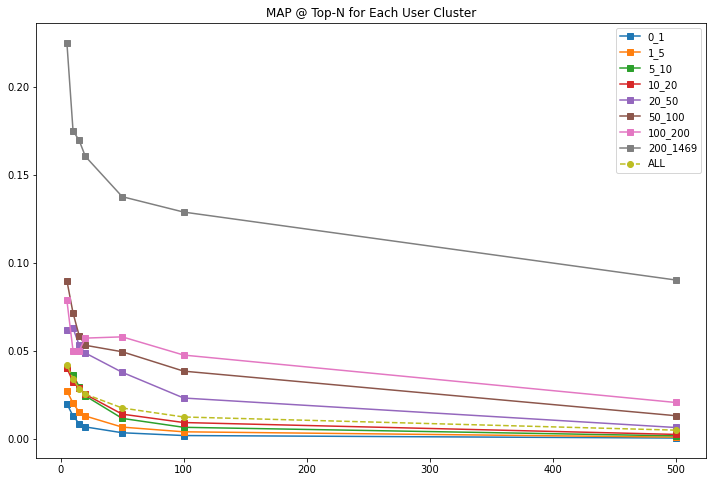

In [722]:
def _apk(actual, predicted, k=10):
    if len(predicted)>k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i,p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i+1.0)

    if not actual:
        return 0.0

    if len(predicted) > 0:
        return num_hits / k #len(predicted)  # 若分母是长度,则结果与我的metrics相同,若除以k, 则不同
    else:
        return 0

def mapk(actual, predicted, k=10):
    return np.mean([_apk(a,p,k) for a,p in zip(actual, predicted)])

def metrics_map(f=mapk, res=test_UP):
    plt.rcParams["figure.figsize"] = (12,8)
    ks = list(accs.keys()) #[500, 100, 50, 20, 15, 10, 5]
    for _,v in user_clusters.items():
      maps = {}
      v = set(v) & set(df_test.userID)
      for k in ks:
        maps[k] = f(res.true[v],res.pred[v], k=k)
      pd.Series(maps).plot(style='s-')
    map_all = pd.Series([f(res.true,res.pred, k=k) for k in ks])
    map_all.index=ks
    map_all.plot(style='o--')
    legends = list(user_clusters.keys())
    legends.append('ALL')
    plt.legend(legends)
    plt.title(f"MAP @ Top-N for Each User Cluster")
    return map_all
    
metrics_map().sort_index() # all user-clusters, 

<AxesSubplot:ylabel='Frequency'>

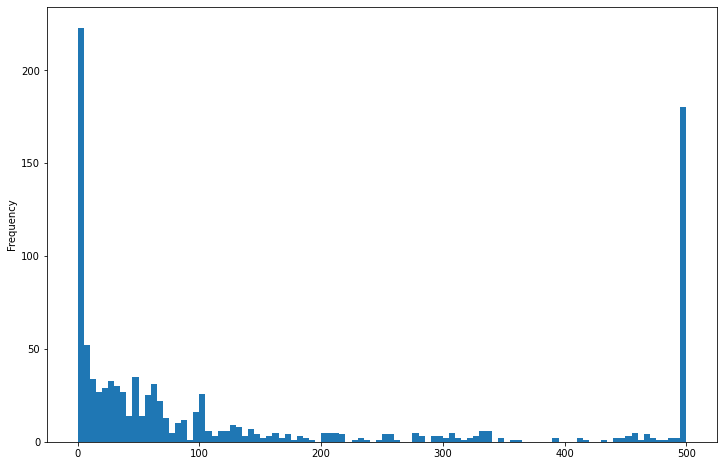

In [734]:
test_UP.pred.apply(len).plot.hist(bins=100)

In [729]:
test_UP.pred.apply(len).value_counts() # 178 users don't have prediction

0      178
500    177
26      19
8       15
4       15
      ... 
172      1
171      1
170      1
167      1
135      1
Name: pred, Length: 205, dtype: int64

In [739]:
test_UP.pred.apply(len).value_counts()[1] # 11 users only have 1 predictions

11

In [738]:
test_UP.pred.apply(len).mean(), test_UP.pred.apply(len).median()

(149.74592521572387, 55.0)

# Results

In [104]:
res_cf.sort_index()  # 3.1594696044921875 s

5      0.029344
10     0.023205
15     0.019105
20     0.016927
50     0.012730
100    0.009539
500    0.005272
dtype: float64

In [102]:
res_bmf # 13.788280010223389 s

5      0.001665
10     0.001353
15     0.001323
20     0.001613
50     0.001540
100    0.001270
500    0.000664
dtype: float64

In [103]:
res_nmf # 16.277201890945435 s

5      0.008117
10     0.007596
15     0.006958
20     0.007232
50     0.005578
100    0.004672
500    0.002776
dtype: float64

In [699]:
res_hcf # 0.8955106735229492 s 并集无序

5      0.029930
10     0.030565
15     0.029910
20     0.030425
50     0.030213
100    0.030822
500    0.030891
dtype: float64

In [682]:
res_hcf # 1.2415876388549805 s 权重排序

5      0.048146
10     0.043317
15     0.039753
20     0.038143
50     0.035276
100    0.034006
500    0.031895
dtype: float64

In [723]:
# acc metrics divided by k instead length of prediction
# 5      0.041994
# 10     0.034036
# 15     0.028444
# 20     0.025312
# 50     0.017430
# 100    0.012320
# 500    0.004846
# dtype: float64

In [934]:
pd.Series(dict([(k, np.array(v).mean()) for k,v in accs.items()])).sort_index() # 权重排序 合并小类(只有top5更优) acc

5      0.048338
10     0.043125
15     0.039455
20     0.037757
50     0.034879
100    0.033593
500    0.031487
dtype: float64